In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import f_oneway

In [2]:
wdir = os.path.abspath('/content/drive/MyDrive/Colab Notebooks/Zomato')
with open(os.path.join(wdir, 'data', 't1_cleaned.pkl'), 'rb') as f:
    basedf = pickle.load(f)

In [3]:
basedf.head()

,online_order,book_table,rating,votes,rest_type,cuisines,cost_for_two,listing_type,locality
0,Yes,Yes,4.1,775,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Yes,No,4.1,787,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,Yes,No,3.8,918,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,No,No,3.7,88,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,No,No,3.8,166,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


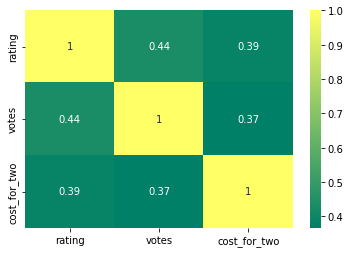

In [4]:
sns.heatmap(basedf.corr(), annot=True, cmap='summer')

In [5]:
def barplot_1(df, x_col, y_col, layout_op, color='rgb(0,150,150)'):
    grouped = df.groupby(x_col, as_index=False).mean().sort_values(y_col, ascending=False)
    fig = go.Figure()
    fig.add_trace(go.Bar(y=grouped[y_col], x=grouped[x_col], marker_color=color))
    # fig.update_layout(width=450, height=300)
    fig.update_layout(**layout_op)
    fig.update_traces()
    fig.show()

layout_op = dict(width=600, height=400)
barplot_1(basedf, 'listing_type', 'rating', layout_op)
barplot_1(basedf, 'listing_type', 'cost_for_two', layout_op, 'rgb(100,0,100)')

### Observations
- Rating is high for places serving alcohol - pubsm, bars, and breweries.
- Buffet rating is also high. But the reason could be that they offer large variety of items and that the cost for two is as much as bars and pubs.
- Remaining places are relatively cheap and attracts a large volume of customers.

In [6]:
def eda_importance(df, input_type, y_col, x_col=None, base_model=None):
    if input_type == 'cat_raw':
        ohe = OneHotEncoder(sparse=False)
        transformed = ohe.fit_transform(df[x_col].values.reshape(-1,1))    
    elif input_type == 'cat_ohe':
        transformed = df.drop(y_col, axis=1)
    elif input_type == 'num':
        transformed = df[[x_col]]
    if base_model is None:
        # print('Using LR')
        model = LinearRegression()
    else:
        # print('Using RF')
        model = RandomForestRegressor(100)
    x, y = transformed, df[y_col].values
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r2, rmse

In [8]:
lr_res, rf_res = [], []
cat_cols = ['online_order', 'book_table', 'listing_type', 'locality']
num_cols = ['cost_for_two', 'votes']

for col in cat_cols:
    r2, rmse = eda_importance(basedf, 'cat_raw', 'rating', col)
    lr_res.append([col, r2, rmse])
    r2, rmse = eda_importance(basedf, 'cat_raw', 'rating', col, 'rf')
    rf_res.append([col, r2, rmse])

for col in num_cols:
    r2, rmse = eda_importance(basedf, 'num', 'rating', col)
    lr_res.append([col, r2, rmse])
    r2, rmse = eda_importance(basedf, 'num', 'rating', col, 'rf')
    rf_res.append([col, r2, rmse])

lr_res = pd.DataFrame(lr_res, columns = ['col', 'r2', 'rmse'])
rf_res = pd.DataFrame(rf_res, columns = ['col', 'r2', 'rmse'])
display(lr_res.sort_values('rmse'))
display(rf_res.sort_values('rmse'))

,col,r2,rmse
5,votes,0.189448,0.396116
1,book_table,0.181535,0.398045
4,cost_for_two,0.148521,0.405994
2,listing_type,0.043139,0.430385
3,locality,0.030921,0.433124
0,online_order,0.004744,0.438935


,col,r2,rmse
5,votes,0.479040,0.317566
4,cost_for_two,0.186386,0.396864
1,book_table,0.181534,0.398045
2,listing_type,0.043141,0.430384
3,locality,0.030917,0.433125
0,online_order,0.004757,0.438932


In [50]:
# Cuisines column is not in proper shape
all_cuisines = []
for item in basedf['cuisines'].unique():
    sub_items = item.split(',')
    for sub_item in sub_items:
        if sub_item.strip() not in all_cuisines:
            all_cuisines.append(sub_item.strip())
arr = np.zeros((basedf.shape[0], len(all_cuisines)))
for i in range(arr.shape[0]):
    for item in basedf['cuisines'][i].split(','):
        elem = item.strip()
        ind = all_cuisines.index(elem)
        arr[i, ind] = 1
    
cuisines_df = pd.DataFrame(arr, columns = all_cuisines)
cuisines_df = pd.concat([cuisines_df, basedf[['rating']]], axis=1)

r2, rmse = eda_importance(cuisines_df, 'cat_ohe', 'rating')
res = res.append({'col' : 'cuisines', 'r2' : r2, 'rmse' : rmse}, ignore_index=True)

In [51]:
# Similar to cuisines, we need to process restaurant types as well
all_types = []
for item in basedf['rest_type'].unique():
    sub_items = item.split(',')
    for sub_item in sub_items:
        if sub_item.strip() not in all_types:
            all_types.append(sub_item.strip())
arr = np.zeros((basedf.shape[0], len(all_types)))
for i in range(arr.shape[0]):
    for item in basedf['rest_type'][i].split(','):
        elem = item.strip()
        ind = all_types.index(elem)
        arr[i, ind] = 1
    
rest_types_df = pd.DataFrame(arr, columns = all_types)
rest_types_df = pd.concat([types_df, basedf[['rating']]], axis=1)

r2, rmse = eda_importance(rest_types_df, 'cat_ohe', 'rating')
res = res.append({'col' : 'rest_type', 'r2' : r2, 'rmse' : rmse}, ignore_index=True)

In [52]:
# Importance based on LinearRegression model
res.sort_values('rmse')

,col,r2,rmse
6,cuisines,0.217277,0.389257
5,votes,0.189448,0.396116
1,book_table,0.181535,0.398045
7,rest_type,0.173990,0.399876
4,cost_for_two,0.148521,0.405994
2,listing_type,0.043139,0.430385
3,locality,0.030921,0.433124
0,online_order,0.004744,0.438935


### Cuisines
- There is a fair bit of variation in cuisines. Restaurants offering certain cuisines tend to have a higher rating - eg: Japanese, Mediterranean, European, etc. 
- Both Linear regression and Random forest find it equally useful because the feature is One Hot encoded and its relationship with rating column should be very close to being linear.

In [53]:
# Cuisines
dct = {}
for c in all_cuisines:
    if cuisines_df[c].sum()>50:
        mean_rating = cuisines_df[[c, 'rating']].groupby(c).mean().iloc[1].values[0]
        dct[c] = mean_rating

grouped = pd.DataFrame({'cuisine' : list(dct.keys()), 'rating' : list(dct.values())})
grouped.sort_values('rating', ascending=False)

layout_op = dict(width=1200, height=400)
barplot_1(grouped, 'cuisine', 'rating', layout_op)

### Votes
- With linear regression, number of votes does not play a role in the final rating of a restaurant. However, Random Forest finds is fairly useful. This is because of the non-linear relationship between votes and rating. 
- When the number of votes is low, rating varies all over the range. However, for higher number of votes, rating seems to be fairly high. As number of votes goes up, average rating also increases. 
- A possible explanation for this behaviour is that customers tend to leave a good impression through votes or reviews when the restaurant is famous/highly successful. 

In [16]:
# Votes
px.scatter(x='votes', y='rating', data_frame=basedf, height=400, width=600)

### Book Table Service
- There is a noticeable separation between the two classes and this indicates that the feature could often be useful. 
- Based on direct model building, book table feature is not extremely useful but because of the plot below, we can keep the feature.
- Restaurants offering this service tend to have a higher rating with median falling around 4.25. Same value for the negative class is only around 3.75. Both classes follow a right tailed distribution when it comes to rating column.

In [23]:
# Book table service
px.box(basedf, x='book_table', y='rating', height=400, width=600)

### Restaurant Types
- As per the model based feature importance estimation, restaurant type is slightly useful in predicting the rating of a restaurant. 
- Plot below shows that certain class of restaurants end up with higher average rating while others are noticeably below.
- Fine diners, bars, and pubs usually end up with higher rating. Places offering food and beverages to a large number of people at smaller prices seem to end up getting lowest rating out of all kinds. 
- When service is offered to a large variety of customers, the rating can vary significantly as the chance of getting a bad rating is high. 

In [54]:
dct = {}
for c in all_types:
    if types_df[c].sum()>50:
        mean_rating = types_df[[c, 'rating']].groupby(c).mean().iloc[1].values[0]
        dct[c] = mean_rating

grouped = pd.DataFrame({'rest_type' : list(dct.keys()), 'rating' : list(dct.values())})

# grouped.sort_values('rating', ascending=False)
# layout_op = dict(width=1000, height=400)
# barplot_1(grouped, 'rest_type', 'rating', layout_op)

dct = {'Bar' : ['Bar', 'Pub', 'Microbrewery'], 'Fine Dining' : ['Fine Dining'],
        'Normal Restaurant' : ['Casual Dining', 'Lounge'], 'Cafe' : ['Cafe', 'Dessert Parlor'],
        'Small Shops' : ['Bakery', 'Kiosk', 'Sweet Shop', 'Quick Bites', 'Beverage Shop'],
        'Mass Dining' : ['Mess', 'Food Court'], 'Delivery/Takeout' : ['Delivery', 'Takeout']}

def func(x):
    for k in dct.keys():
        if x in dct[k]:
            return k
    return 'Others'

grouped['rest_type'] = grouped['rest_type'].apply(func)
layout_op = dict(width=1000, height=400)
barplot_1(grouped, 'rest_type', 'rating', layout_op)

### Cost for two
- The relationship is almost inexistent as seen in the plot below. However, for costly retaurants (cost of two above 1500 approximately), the rating is usually high with average slightly above 4.0
- This is likely to be unuseful for linear models but tree based models may be able to make use of this feature to predict rating of costly restaurants with more accuracy.

In [24]:
# Votes
px.scatter(x='cost_for_two', y='rating', data_frame=basedf, height=400, width=600)

## Main takeaways from EDA
- The relationship between number of votes and rating is not entirely independent. Restaurants when rated high consistently, tend to receive many votes from users. However, it still remains as a fact that if a restaurant has large number of votes, the rating is likely to be high. 
- When offering exotic cuisines, retaurants are likely to be rated higher. Indian restaurants offering Indian cuisines tend to receive an average rating slightly below 4. This could be because of the variety of meals and customer's expectations regarding how a dish should be prepared. 
- For new restaurants, the restaurant type would already be fixed. So to increase the rating, it can consider offering more variety in the cuisines and offering services like table booking and optional online ordering. Serving the meals to a focused customer group is highly recommended as the rating is severely affected by how large the audience is.|